In [1]:
from src.classes.handlers.crypto_data.BinanceHandler import BinanceHandler
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard
import time
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
log_dir = "logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [3]:
file_path = 'btc_data.csv'
params = {
    'symbol': 'BTCUSDT',
    'timeframe': '1d',
    'file_name': file_path
}
data_handler = BinanceHandler(params)
data_handler.handle()
crypto_data = pd.read_csv(file_path)
crypto_data

,Timestamp,Open,High,Low,Close,Volume
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...,...
2337,1704844800000,46110.00,47695.93,44300.36,46653.99,89911.412030
2338,1704931200000,46654.00,48969.48,45606.06,46339.16,87470.329600
2339,1705017600000,46339.16,46515.53,41500.00,42782.73,86327.937070
2340,1705104000000,42782.74,43257.00,42436.12,42847.99,36118.474640


,Actual_Close,Target,Date
0,4285.08,NaN,2017-08-17
1,4108.37,0.0,2017-08-18
2,4139.98,1.0,2017-08-19
3,4086.29,0.0,2017-08-20
4,4016.00,0.0,2017-08-21
...,...,...,...
2337,46653.99,1.0,2024-01-10
2338,46339.16,0.0,2024-01-11
2339,42782.73,0.0,2024-01-12
2340,42847.99,1.0,2024-01-13


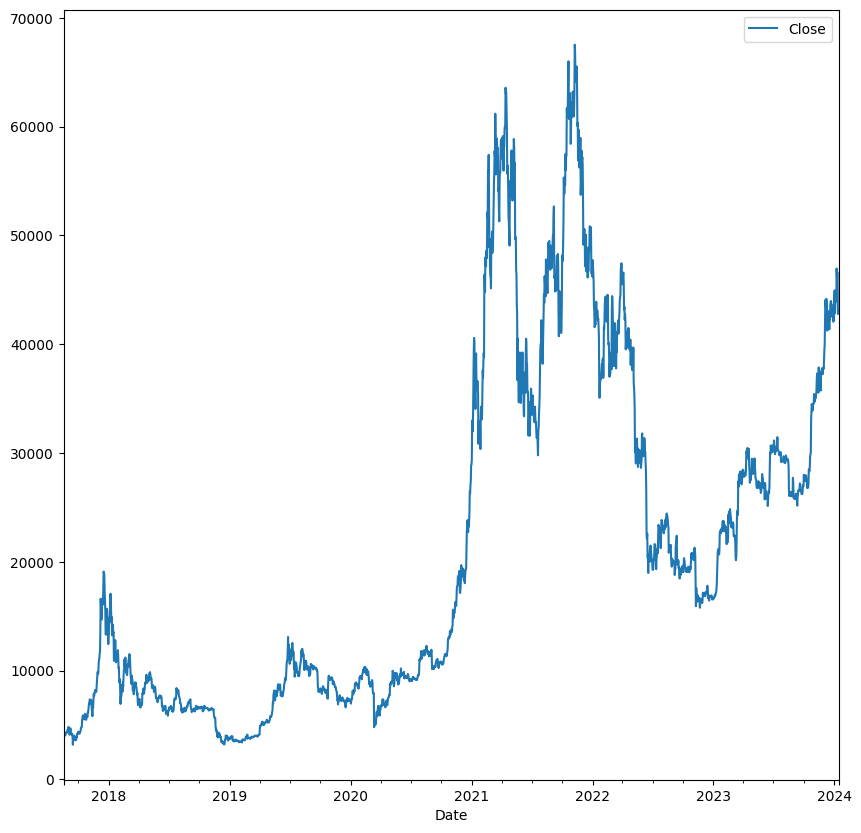

In [4]:
df = pd.DataFrame(crypto_data)
df.rename(columns={'Timestamp': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'] / 1000, unit='s')

df.plot.line(y='Close', x='Date', figsize=(10, 10))

data = df[['Close']]
data = data.rename(columns={'Close': 'Actual_Close'})
data['Target'] = df['Close'].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])
data['Date'] = df['Date']
data

In [5]:
print(df.head())
print(df.shape)
print(df.columns)

        Date     Open     High      Low    Close       Volume
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060
(2342, 6)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [6]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = ((delta.where(delta > 0, 0)).rolling(window=window).mean())
    loss = ((-delta.where(delta < 0, 0)).rolling(window=window).mean())
    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [7]:
df['RSI'] = calculate_rsi(df['Close'], 14)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
df

,Date,Open,High,Low,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,NaN,0.000000,0.000000,0.000000
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,NaN,-14.096524,-2.819305,-11.277219
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,NaN,-22.458570,-6.747158,-15.711412
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,NaN,-33.037055,-12.005137,-21.031918
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,NaN,-46.555731,-18.915256,-27.640475
...,...,...,...,...,...,...,...,...,...,...
2337,2024-01-10,46110.00,47695.93,44300.36,46653.99,89911.412030,63.133239,1083.236862,845.976562,237.260300
2338,2024-01-11,46654.00,48969.48,45606.06,46339.16,87470.329600,66.095284,1129.523320,902.685914,226.837407
2339,2024-01-12,46339.16,46515.53,41500.00,42782.73,86327.937070,52.420154,869.211761,895.991083,-26.779322
2340,2024-01-13,42782.74,43257.00,42436.12,42847.99,36118.474640,52.394175,660.564337,848.905734,-188.341397


In [8]:
def create_dataset(df, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(df)):
        x.append(df[i - sequence_length:i])
        y.append(df.iloc[i]['Close'])
    return np.array(x), np.array(y)

In [9]:
df.dropna(subset=['RSI'], inplace=True)
if 'High' in df.columns and 'Low' in df.columns:
    df.drop(['High', 'Low'], axis=1, inplace=True)
features_columns = ['Close', 'Volume', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram']

sequence_length = 60
n_features = len(features_columns)

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

df_scaled = scaler_features.fit_transform(df[features_columns])
df_scaled = pd.DataFrame(df_scaled, columns=features_columns)
print(df_scaled)

training_data_len = int(np.ceil(len(df_scaled) * 0.8))
train_data_scaled = scaler_features.transform(df_scaled[features_columns])
x_train, y_train = create_dataset(df_scaled[:training_data_len], sequence_length)
x_test, y_test = create_dataset(df_scaled[training_data_len:], sequence_length)

         Close    Volume       RSI      MACD  Signal_Line  MACD_Histogram
0     0.021234  0.000672  0.611377  0.496451     0.496744        0.585124
1     0.023872  0.000341  0.665787  0.499024     0.498376        0.589072
2     0.025582  0.000346  0.806929  0.501804     0.500324        0.592797
3     0.019944  0.000831  0.594265  0.501062     0.501711        0.586179
4     0.020518  0.000518  0.628031  0.500657     0.502726        0.581804
...        ...       ...       ...       ...          ...             ...
2324  0.675585  0.117850  0.615763  0.596477     0.590889        0.648106
2325  0.670691  0.114639  0.647122  0.600962     0.597233        0.644667
2326  0.615413  0.113137  0.502344  0.575741     0.596484        0.560983
2327  0.616427  0.047107  0.502069  0.555526     0.591217        0.507674
2328  0.617111  0.009874  0.498660  0.539299     0.583255        0.475891

[2329 rows x 6 columns]


In [10]:
def calculate_percentage_error(real_values, predicted_values):
    percentage_errors = []
    for real, predicted in zip(real_values, predicted_values):
        if real != 0: 
            percentage_error = abs(real - predicted) / real * 100
            percentage_errors.append(percentage_error)
        else:
            percentage_errors.append(0) 
    return percentage_errors

In [11]:
crypto_data

,Timestamp,Open,High,Low,Close,Volume
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...,...
2337,1704844800000,46110.00,47695.93,44300.36,46653.99,89911.412030
2338,1704931200000,46654.00,48969.48,45606.06,46339.16,87470.329600
2339,1705017600000,46339.16,46515.53,41500.00,42782.73,86327.937070
2340,1705104000000,42782.74,43257.00,42436.12,42847.99,36118.474640


In [12]:
# set params for Bollinger Bands (BB)
sma_period = 20  #using for 20-period SMA
std_dev_multiplier = 2  #standart deviation

df['Low'] = crypto_data['Low']
df['High'] = crypto_data['High']

# calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=sma_period).mean()
df['Upper_BB'] = df['SMA'] + df['Close'].rolling(window=sma_period).std() * std_dev_multiplier
df['Lower_BB'] = df['SMA'] - df['Close'].rolling(window=sma_period).std() * std_dev_multiplier

# Calculate the Money Flow Index (MFI)
typical_price = (df['Close'] + df['Low'] + df['High']) / 3
raw_money_flow = typical_price * df['Volume']
positive_flow = raw_money_flow.where(typical_price > typical_price.shift(1), 0)
negative_flow = raw_money_flow.where(typical_price < typical_price.shift(1), 0)

# Calculate the money flow ratio
positive_flow_sum = positive_flow.rolling(window=14).sum()
negative_flow_sum = negative_flow.rolling(window=14).sum()
money_flow_ratio = positive_flow_sum / negative_flow_sum

# Calculate the MFI
mfi = 100 - (100 / (1 + money_flow_ratio))
df['MFI'] = mfi

# set params for Relative Volatility Index (RVI)
rvi_period = 10  # define the period for RVI, for example 10

# calculate Relative Volatility Index (RVI)
standard_deviation = df['Close'].rolling(window=rvi_period).std()
mean_deviation = standard_deviation.rolling(window=rvi_period).mean()
df['RVI'] = standard_deviation / mean_deviation.where(mean_deviation != 0, np.nan)

# remove starting NA values after calculate indicators
df.dropna(inplace=True)

In [13]:
df

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram,Low,High,SMA,Upper_BB,Lower_BB,MFI,RVI
32,2017-09-18,3690.00,4035.01,1030.006455,48.958800,-156.191648,-103.250397,-52.941251,3690.00,4123.20,4210.0975,5042.872610,3377.322390,44.214191,1.080327
33,2017-09-19,4060.00,3910.04,902.332129,42.354120,-148.398764,-112.280070,-36.118693,3830.91,4089.97,4177.8425,5004.295390,3351.389610,45.474232,0.978981
34,2017-09-20,3910.04,3900.00,720.935076,36.872937,-141.402985,-118.104653,-23.298332,3820.00,4046.08,4136.5980,4929.763426,3343.432574,39.315184,0.921318
35,2017-09-21,3889.99,3609.99,1001.654084,31.727663,-157.445233,-125.972769,-31.472463,3567.00,3910.00,4075.3520,4829.698563,3321.005437,34.078954,0.835031
36,2017-09-22,3592.84,3595.87,838.966425,36.609708,-169.346079,-134.647431,-34.698648,3505.55,3750.00,4031.5385,4790.624351,3272.452649,35.298268,0.735832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2024-01-10,46110.00,46653.99,89911.412030,63.133239,1083.236862,845.976562,237.260300,44300.36,47695.93,43855.5725,46689.188207,41021.956793,52.651483,1.235206
2338,2024-01-11,46654.00,46339.16,87470.329600,66.095284,1129.523320,902.685914,226.837407,45606.06,48969.48,43974.0785,47018.106438,40930.050562,61.156476,1.218401
2339,2024-01-12,46339.16,42782.73,86327.937070,52.420154,869.211761,895.991083,-26.779322,41500.00,46515.53,43928.1070,47016.867880,40839.346120,57.634113,1.292652
2340,2024-01-13,42782.74,42847.99,36118.474640,52.394175,660.564337,848.905734,-188.341397,42436.12,43257.00,43920.9315,47019.504966,40822.358034,56.666568,1.229990


In [14]:
import requests
import pandas as pd


def get_blockchain_data():
    url = 'https://api.blockchain.info/stats'
    response = requests.get(url)
    data = response.json()
    blockchain_data = pd.DataFrame([data])
    blockchain_data = blockchain_data[['hash_rate']]
    blockchain_data['Date'] = pd.to_datetime('today')
    return blockchain_data


blockchain_data = get_blockchain_data()

df['Date'] = pd.to_datetime(df['Date'])
current_hash_rate = blockchain_data.at[0, 'hash_rate']
df['hash_rate'] = current_hash_rate

df

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram,Low,High,SMA,Upper_BB,Lower_BB,MFI,RVI,hash_rate
32,2017-09-18,3690.00,4035.01,1030.006455,48.958800,-156.191648,-103.250397,-52.941251,3690.00,4123.20,4210.0975,5042.872610,3377.322390,44.214191,1.080327,5.239691e+11
33,2017-09-19,4060.00,3910.04,902.332129,42.354120,-148.398764,-112.280070,-36.118693,3830.91,4089.97,4177.8425,5004.295390,3351.389610,45.474232,0.978981,5.239691e+11
34,2017-09-20,3910.04,3900.00,720.935076,36.872937,-141.402985,-118.104653,-23.298332,3820.00,4046.08,4136.5980,4929.763426,3343.432574,39.315184,0.921318,5.239691e+11
35,2017-09-21,3889.99,3609.99,1001.654084,31.727663,-157.445233,-125.972769,-31.472463,3567.00,3910.00,4075.3520,4829.698563,3321.005437,34.078954,0.835031,5.239691e+11
36,2017-09-22,3592.84,3595.87,838.966425,36.609708,-169.346079,-134.647431,-34.698648,3505.55,3750.00,4031.5385,4790.624351,3272.452649,35.298268,0.735832,5.239691e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2024-01-10,46110.00,46653.99,89911.412030,63.133239,1083.236862,845.976562,237.260300,44300.36,47695.93,43855.5725,46689.188207,41021.956793,52.651483,1.235206,5.239691e+11
2338,2024-01-11,46654.00,46339.16,87470.329600,66.095284,1129.523320,902.685914,226.837407,45606.06,48969.48,43974.0785,47018.106438,40930.050562,61.156476,1.218401,5.239691e+11
2339,2024-01-12,46339.16,42782.73,86327.937070,52.420154,869.211761,895.991083,-26.779322,41500.00,46515.53,43928.1070,47016.867880,40839.346120,57.634113,1.292652,5.239691e+11
2340,2024-01-13,42782.74,42847.99,36118.474640,52.394175,660.564337,848.905734,-188.341397,42436.12,43257.00,43920.9315,47019.504966,40822.358034,56.666568,1.229990,5.239691e+11


In [15]:
X = df[features_columns]
y = df['Close']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_price.fit(df[['Close']]) 

MinMaxScaler()

In [17]:
from keras.src.layers import Bidirectional
from keras.src.callbacks import ReduceLROnPlateau
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data preparation
df.dropna(subset=['RSI'], inplace=True)
df.drop(['High', 'Low'], axis=1, errors='ignore', inplace=True)
df['Mid_Price'] = (df['Open'] + df['Close']) / 2

# Calculate SMA_50 and add to df
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Update your features list
features_columns = ['Close', 'Volume', 'Signal_Line', 'Mid_Price', 'SMA_50', 'SMA_200']

# Handling any NaN values
df.dropna(inplace=True)

# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler_features.fit_transform(df[features_columns])
df_scaled = pd.DataFrame(df_scaled, columns=features_columns)


# Define create_dataset function
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back, 0])  # Assuming 'Close' is at index 0
    return np.array(X), np.array(Y)


# Prepare the dataset
look_back = 60
X, Y = create_dataset(df_scaled.values, look_back)

# Splitting data to training and testing sets
training_data_len = int(len(df_scaled) * 0.8)
X_train, X_test, Y_train, Y_test = X[:training_data_len], X[training_data_len:], Y[:training_data_len], Y[training_data_len:]

# Define the GRU model
n_features = len(features_columns)
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(look_back, n_features))))
model.add(Dropout(0.4)) 
model.add(Bidirectional(GRU(64, return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(1))

# Compile the model
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Fit the model
model.fit(X_train, Y_train, epochs=150, batch_size=16, validation_data=(X_test, Y_test),
          callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/150
106/106 [==============================] - 27s 111ms/step - loss: 0.0171 - val_loss: 8.0651e-04 - lr: 5.0000e-04
Epoch 2/150
106/106 [==============================] - 8s 73ms/step - loss: 0.0060 - val_loss: 5.6842e-04 - lr: 5.0000e-04
Epoch 3/150
106/106 [==============================] - 7s 69ms/step - loss: 0.0042 - val_loss: 6.2731e-04 - lr: 5.0000e-04
Epoch 4/150
106/106 [==============================] - 7s 67ms/step - loss: 0.0040 - val_loss: 4.7930e-04 - lr: 5.0000e-04
Epoch 5/150
106/106 [==============================] - 7s 68ms/step - loss: 0.0034 - val_loss: 6.6019e-04 - lr: 5.0000e-04
Epoch 6/150
106/106 [==============================] - 7s 69ms/step - loss: 0.0028 - val_loss: 3.7159e-04 - lr: 5.0000e-04
Epoch 7/150
106/106 [==============================] - 7s 68ms/step - loss: 0.0030 - val_loss: 4.1537e-04 - lr: 5.0000e-04
Epoch 8/150
106/106 [==============================] - 7s 68ms/step - loss: 0.0031 - val_loss: 9.1627e-04 - lr: 5.0000e-04
Epoch 9/150
10

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure X_test is used for prediction, and it has the correct shape
predicted = model.predict(X_test)

# Inverse transform the predicted and real values
# Make sure scaler_price was fitted to the 'Close' prices initially
predicted_prices = scaler_price.inverse_transform(predicted)
real_values = scaler_price.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(real_values, predicted_prices)
mae = mean_absolute_error(real_values, predicted_prices)
r2 = r2_score(real_values, predicted_prices)

# Prepare data for visualization
visualize = {
    'real': real_values.flatten(),
    'predicted': predicted_prices.flatten()
}

# Print evaluation metrics
print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

# Create a DataFrame for visualization
df_vis = pd.DataFrame(visualize)
df_vis


# results: MSE: 651167, MAE:671.39, R^2: 0.9786

12/12 [==============================] - 4s 27ms/step
MSE: 862923.5480276576, MAE: 647.045289040978, R^2: 0.9773024622663684


,real,predicted
0,21134.81,21129.251953
1,20677.47,21405.470703
2,21071.59,21293.990234
3,22667.21,21375.789062
4,22783.55,21910.167969
...,...,...
358,46653.99,45208.875000
359,46339.16,45644.390625
360,42782.73,45830.203125
361,42847.99,44669.980469


In [19]:

predicted_train_prices = model.predict(X_train)

# Создание новой целевой переменной для направления движения цены
# Если предсказанная цена больше текущей, то 1 (вверх), иначе 0 (вниз)
Y_train_direction = np.where(predicted_train_prices[:-1].flatten() < Y_train[1:], 1, 0)

# Теперь необходимо создать дополнительный датасет для обучения классификационной модели
X_train_direction = X_train[1:]  # Убираем первый элемент, так как для него нет предсказания направления

# Создание и обучение классификационной модели для предсказания направления
direction_model = Sequential()
direction_model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(look_back, n_features))))
direction_model.add(Dropout(0.4)) 
direction_model.add(Bidirectional(GRU(64, return_sequences=False)))
direction_model.add(Dropout(0.4))
direction_model.add(Dense(1, activation='sigmoid'))  # Используем сигмоидальную функцию активации для классификации

direction_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение классификационной модели
direction_model.fit(X_train_direction, Y_train_direction, epochs=150, batch_size=16, callbacks=[early_stopping, reduce_lr])

# Предсказание направления движения цены на тестовых данных
# Для этого сначала необходимо получить предсказанные цены моделью регрессии
predicted_test_prices = model.predict(X_test)

# Создание тестового набора для Y_test_direction
Y_test_direction = np.where(predicted_test_prices[:-1].flatten() < Y_test[1:], 1, 0)
X_test_direction = X_test[1:]  # Убираем первый элемент для соответствия Y_test_direction

# Оценка классификационной модели на тестовых данных
test_direction_accuracy = direction_model.evaluate(X_test_direction, Y_test_direction)


53/53 [==============================] - 2s 30ms/step
Epoch 1/150
106/106 [==============================] - 21s 66ms/step - loss: 0.5853 - accuracy: 0.6959 - lr: 5.0000e-04
Epoch 2/150
106/106 [==============================] - 7s 63ms/step - loss: 0.5516 - accuracy: 0.7184 - lr: 5.0000e-04
Epoch 3/150
106/106 [==============================] - 7s 64ms/step - loss: 0.5447 - accuracy: 0.7072 - lr: 5.0000e-04
Epoch 4/150
106/106 [==============================] - 8s 80ms/step - loss: 0.5390 - accuracy: 0.7297 - lr: 5.0000e-04
Epoch 5/150
106/106 [==============================] - 7s 65ms/step - loss: 0.5409 - accuracy: 0.7232 - lr: 5.0000e-04
Epoch 6/150
106/106 [==============================] - 7s 66ms/step - loss: 0.5447 - accuracy: 0.7285 - lr: 5.0000e-04
Epoch 7/150
106/106 [==============================] - 7s 70ms/step - loss: 0.5379 - accuracy: 0.7327 - lr: 5.0000e-04
Epoch 8/150
106/106 [==============================] - 10s 91ms/step - loss: 0.5398 - accuracy: 0.7309 - lr: 5.0

In [20]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Предположим, что df - ваш DataFrame, и он уже содержит все необходимые признаки
# Включая 'Close', 'Volume', 'RSI', 'MACD' и другие технические индикаторы

# Нормализация признаков
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Создание целевой переменной для классификации
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Определение функции для создания датасета
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Создание датасета
time_steps = 60
X, y = create_dataset(scaled_data, df['Target'].values, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Расчет весов классов
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i: weights[i] for i in range(2)}

# Создание модели
model = Sequential()
model.add(Bidirectional(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(50)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)]

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    class_weight=class_weights, callbacks=callbacks)


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [ ]:
test_direction_accuracy

In [ ]:
last_sequence = x_test[-1:]
future_predictions = []

for _ in range(10):
    current_pred = model.predict(last_sequence)
    future_predictions.append(current_pred[0, 0])

    new_sequence = np.roll(last_sequence, -1, axis=1)
    new_sequence[0, -1, :] = np.zeros(last_sequence.shape[2])
    new_sequence[0, -1, 0] = current_pred[0, 0]  

    last_sequence = new_sequence

future_prices = scaler_price.inverse_transform(np.array(future_predictions).reshape(-1, 1))

for i, price in enumerate(future_prices):
    print(f"Day {i + 1}: Predicted Price - {price[0]}")

In [ ]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')

df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')

In [ ]:
# import plotly.graph_objs as go
# from plotly.offline import plot
# import matplotlib.pyplot as plt
# 
# 
# real_data = go.Scatter(
#     x=df.index, 
#     y=df['Close'], 
#     mode='lines',
#     name='Real Data'
# )
# 
# predicted_data = go.Scatter(
#     x=df.index, 
#     y=predicted_prices, 
#     mode='lines',
#     name='Predicted Data'
# )
# 
# SMA_50 = go.Scatter(
#     x=df.index, 
#     y=df['SMA_50'], 
#     mode='lines',
#     name='50-period SMA',
#     line=dict(color='orange')
# )
# 
# SMA_200 = go.Scatter(
#     x=df.index, 
#     y=df['SMA_200'], 
#     mode='lines',
#     name='200-period SMA',
#     line=dict(color='green')
# )
# 
# signal_line = go.Scatter(
#     x=df.index, 
#     y=df['Signal_Line'], 
#     mode='lines',
#     name='Signal_Line',
#     line=dict(color='#ee2122')
# )
# 
# MACD_histogram = go.Scatter(
#     x=df.index, 
#     y=df['MACD_Histogram'], 
#     mode='lines',
#     name='MACD_Histogram',
#     line=dict(color='#f123e1')
# )
# 
# MACD = go.Scatter(
#     x=df.index, 
#     y=df['MACD'], 
#     mode='lines',
#     name='MACD',
#     line=dict(color='#11bbbb')
# )
# 
# RSI = go.Scatter(
#     x=df.index, 
#     y=df['RSI'], 
#     mode='lines',
#     name='RSI',
#     line=dict(color='#bb12bb')
# )
# 
# fig = go.Figure()
# 
# fig.add_trace(real_data)
# fig.add_trace(predicted_data)
# fig.add_trace(SMA_50)
# fig.add_trace(SMA_200)
# fig.add_trace(signal_line)
# fig.add_trace(MACD_histogram)
# fig.add_trace(MACD)
# fig.add_trace(RSI)
# 
# fig.update_layout(
#     title='BTC Real/Predicted with Moving Averages',
#     xaxis_title='Time Periods',
#     yaxis_title='Values',
#     hovermode='x'
# )
# 
# plot(fig, filename='interactive_graph.html')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Определение SMA
df['SMA_50'] = df['Close'].rolling(window=50).mean().bfill().ffill()
df['SMA_200'] = df['Close'].rolling(window=200).mean().bfill().ffill()

# Расчет индекса для предсказанных цен
start_point = training_data_len + sequence_length
end_point = start_point + len(predicted_prices)
predicted_index = df.index[start_point:end_point]

# Создание DataFrame для предсказанных цен
# Предполагаем, что predicted_prices - это массив numpy, полученный после обратного масштабирования
predicted_df = pd.DataFrame(predicted_prices, index=predicted_index, columns=['Predicted'])

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Real Data')
plt.plot(predicted_df['Predicted'], label='Predicted Data')

# Ваши линии для SMA, если вы хотите их добавить
# plt.plot(df['SMA_50'], label='50-period SMA', color='orange') 
# plt.plot(df['SMA_200'], label='200-period SMA', color='green')

# Настройки графика
plt.title('BTC Real/Predicted with Moving Averages')
plt.xlabel('Time Periods')
plt.ylabel('Values')
plt.legend()

# Отображение графика
plt.show()


In [ ]:
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt

predicted_index = df.index[start_point:end_point]
predicted_prices_series = pd.Series(predicted_prices.flatten(), index=predicted_index)

df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')

df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')

real_data = go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Real Data'
)

predicted_data = go.Scatter(
    x=predicted_index,
    y=predicted_prices_series,
    mode='lines',
    name='Predicted Data'
)

SMA_50 = go.Scatter(
    x=df.index,
    y=df['SMA_50'],
    mode='lines',
    name='50-period SMA',
    line=dict(color='orange')
)

SMA_200 = go.Scatter(
    x=df.index,
    y=df['SMA_200'],
    mode='lines',
    name='200-period SMA',
    line=dict(color='green')
)

signal_line = go.Scatter(
    x=df.index,
    y=df['Signal_Line'],
    mode='lines',
    name='Signal_Line',
    line=dict(color='#ee2122')
)

MACD_histogram = go.Scatter(
    x=df.index,
    y=df['MACD_Histogram'],
    mode='lines',
    name='MACD_Histogram',
    line=dict(color='#f123e1')
)

MACD = go.Scatter(
    x=df.index,
    y=df['MACD'],
    mode='lines',
    name='MACD',
    line=dict(color='#11bbbb')
)

RSI = go.Scatter(
    x=df.index,
    y=df['RSI'],
    mode='lines',
    name='RSI',
    line=dict(color='#bb12bb')
)

fig = go.Figure()

fig.add_trace(real_data)
fig.add_trace(predicted_data)
fig.add_trace(SMA_50)
fig.add_trace(SMA_200)
fig.add_trace(signal_line)
fig.add_trace(MACD_histogram)
fig.add_trace(MACD)
fig.add_trace(RSI)

fig.update_layout(
    title='BTC Real/Predicted with Moving Averages',
    xaxis_title='Time Periods',
    yaxis_title='Values',
    hovermode='x'
)

plot(fig, filename='interactive_graph.html')


In [ ]:
# # Предполагаем, что df_scaled - это ваш масштабированный DataFrame
# features_importance = {}
# original_features = features_columns.copy()
# 
# for feature in original_features:
#     # Удалить признак из набора данных
#     temp_features = original_features.copy()
#     temp_features.remove(feature)
#     temp_df_scaled = df_scaled[temp_features]
# 
#     # Подготовить новые наборы данных
#     x_train_temp, y_train_temp = create_dataset(temp_df_scaled[:training_data_len], sequence_length)
#     x_test_temp, y_test_temp = create_dataset(temp_df_scaled[training_data_len:], sequence_length)
# 
#     # Обучить модель
#     temp_model = build_model(sequence_length, len(temp_features))  # функция build_model должна быть определена
#     temp_model.fit(x_train_temp, y_train_temp, epochs=100, batch_size=32, validation_data=(x_test_temp, y_test_temp), callbacks=[early_stopping, model_checkpoint])
# 
#     # Оценить производительность
#     predictions_temp = temp_model.predict(x_test_temp)
#     mse_temp = mean_squared_error(y_test_temp, predictions_temp)
# 
#     # Сохранить изменение производительности
#     features_importance[feature] = baseline_mse - mse_temp
# 
# # Отобразить изменение производительности
# plt.barh(range(len(features_importance)), list(features_importance.values()), align='center')
# plt.yticks(range(len(features_importance)), list(features_importance.keys()))
# plt.xlabel('Изменение MSE')
# plt.title('Изменение производительности после удаления признака')
# plt.show()
